In [ ]:
def count_frequency(my_list):
    
    count = {}
    
    for item in my_list:
        count[item] = count.get(item, 0) + 1
        
    return count

In [1]:
!pip install bayesian-optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from plotnine import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
import plotly.express as px
import seaborn as sb

In [ ]:
forders = os.listdir('/content/drive/MyDrive/Feed 100~150 10회 가공/실험1/FEED 100 - 10') #폴더설정

In [ ]:
f100 = []
for i in range(0,len(forders)):
  if forders[i].split('.')[1] =='csv':
    file = '/content/drive/MyDrive/Feed 100~150 10회 가공/실험1/FEED 100 - 10/'+forders[i]
    f100.append(file)

In [ ]:
f100_list = [pd.read_csv(i, skiprows=[0]) for i in f100[::-1]] #한 폴더의 데이터프레임 리스트 생성

In [ ]:
f100= []
for i in range(0,10):
  f100_ud= f100_list[i]
  f100_z = f100_ud[f100_ud[' z'] < 0 ] # z값 0 이상 제거
  f100_z['Ref'] = (f100_z[' Ref_upper'] + f100_z[' Ref_lower']) / 2 # Ref 열 추가
  drop = ['hh:mm:ss:ms', ' Sampling Interval', ' Block No', ' G-code', ' G80',
       ' M-code', ' Start', ' mode', ' x', ' y', ' z', ' a', ' b', ' c',
       ' actLoad', ' Ref_upper', ' Ref_lower', ' PLCFOV',
       ' cmdFOV', ' cmdSOV', ' userASCOn', ' userAFCon',
       ' TWon', ' C2', ' C3', ' C4', ' A1', ' A1h', ' A1 chatter',
       ' A2', ' A2H', ' A2 chatter'] # 제거할 열들
  f100_d = f100_z.drop(drop,axis = 1) # 필요없는 열 제거
  f100.append(f100_d) # 데이터리스트에 추가

In [ ]:
scaler = MinMaxScaler()

X_train = []
X_test = []
Y_train = []
Y_test = []

features_col = ['principal component1', 'principal component2']

for i in range(0,10):
    df = f100[i]

    x = df.drop([' C1'], axis=1).values

    pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
    pca.fit
    printcipalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
    
    features = principalDf[features_col].reset_index(drop = True).values
    target = df[' C1'].reset_index(drop = True).values

    (Xtrain, Xtest, Ytrain, Ytest) = train_test_split(features, target, test_size= 0.2, random_state = 109)

    # X_train = np.log1p(X_train) # 로그화
    # X_test = np.log1p(X_test)
    # Y_train = np.log1p(Y_train)
    # Y_test = np.log1p(Y_test)

    Xtrain[ : ] = scaler.fit_transform(Xtrain[ : ]) # 정규화
    Xtest[ : ] = scaler.transform(Xtest[ : ])

    X_train.append(Xtrain)
    X_test.append(Xtest)
    Y_train.append(Ytrain)
    Y_test.append(Ytest)


In [ ]:
before_R2_100 = []
after_R2_100 = []

before_RMSE_100 = []
after_RMSE_100 = []

    
for i in range (0,10):

  # 데이터 준비
  X_train_a = X_train[i]
  Y_train_a = Y_train[i]
  X_test_a = X_test[i]
  Y_test_a = Y_test[i]

  evals = [(X_test_a, Y_test_a)]
  model = XGBRegressor(random_state = 0)
  model.fit(X_train_a, Y_train_a, early_stopping_rounds = 100, eval_set=evals,  verbose=0)

  # 모델 적용
  ## 예측
  preds = model.predict(X_test_a)

  ## 성능 평가
  print('R2 : ', model.score(X_test_a,Y_test_a)) ## 테스트 성능 평가 점수(Accuracy)
  before_R2_100.append(model.score(X_test_a,Y_test_a))

  rmse = np.sqrt(mean_squared_error(preds, Y_test_a))
  print("RMSE: %f" % (rmse))
  before_RMSE_100.append(rmse)

  ## 변수 중요도
  for k, feature in enumerate(principalDf[features_col].columns):
      print(f'{feature} : {model.feature_importances_[k]}')
  print('f100_'+str(i)+' 튜닝 전 \n')


  # 베이지안 최적화
  def xgb_evaluate(colsample_bytree, gamma, max_depth, min_child_weight, eta, subsample):
    
    params = {'colsample_bytree': colsample_bytree,
              'gamma': gamma,
              'max_depth': int(max_depth),
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'eta': eta,
              'objective':'reg:squarederror',
              'eval_metric': 'rmse',
              'n_estimators' : 500,
              'learning_rate' : 0.1}

    evals = [(X_test_a, Y_test_a)]
    model = XGBRegressor(**params, random_state = 0)
    model.fit(X_train_a, Y_train_a, early_stopping_rounds = 100, eval_set=evals,  verbose=0)
    preds = model.predict(X_test_a)
    # r-square 함수사용
    scores = r2_score(Y_test_a, preds)       
 
    return scores
    
  xgb_bo = BayesianOptimization(xgb_evaluate, {'colsample_bytree': (0.5, 1.0),
                                             'eta':(0.01, 0.3),
                                             'gamma': (0, 1),
                                             'max_depth': (10, 30),
                                             'min_child_weight': (0, 5),
                                             'subsample':(0.3, 1.0)},  random_state=0,allow_duplicate_points=True)
 
  xgb_bo.maximize(init_points=5, n_iter=100, acq='ei', verbose = 0)

  evals = [(X_test_a, Y_test_a)]
  model = XGBRegressor(colsample_bytree = xgb_bo.max['params']['colsample_bytree'],
                      eta = xgb_bo.max['params']['eta'],
                      gamma = xgb_bo.max['params']['gamma'],
                      max_depth = int(xgb_bo.max['params']['max_depth']),
                      min_child_weight = xgb_bo.max['params']['min_child_weight'],
                      subsample = xgb_bo.max['params']['subsample'],
                      objective = 'reg:squarederror',
                      eval_metric = 'rmse',
                      n_estimators = 500, random_state = 0)
  model.fit(X_train_a, Y_train_a, early_stopping_rounds = 100, eval_set=evals,  verbose=0)

  # Grid Search 후 모델 적용
  ## 예측
  preds = model.predict(X_test_a)

  ## 성능 평가
  print('R2 : ', model.score(X_test_a,Y_test_a)) ## 테스트 성능 평가 점수(Accuracy)
  after_R2_100.append(model.score(X_test_a,Y_test_a))
  rmse = np.sqrt(mean_squared_error(preds, Y_test_a))
  print("RMSE: %f" % (rmse))
  after_RMSE_100.append(rmse)

  ## 변수 중요도
  for l, feature in enumerate(principalDf[features_col].columns):
      print(f'{feature} : {model.feature_importances_[l]}')
  print('f100_'+str(i)+' 튜닝 후 \n')

[05:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 :  0.9460973790594921
RMSE: 0.304565
principal component1 : 0.048088278621435165
principal component2 : 0.9519116878509521
f100_0 튜닝 전 

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9457    | 0.7744    | 0.2174    | 0.6028    | 20.9      | 2.118     | 0.7521    |
| 2         | 0.9459    | 0.7188    | 0.2686    | 0.9637    | 17.67     | 3.959     | 0.6702    |
| 3         | 0.9463    | 0.784     | 0.2784    | 0.07104   | 11.74     | 0.1011    | 0.8828    |
| 4         | 0.9457    | 0.8891    | 0.2623    | 0.9786    | 25.98     | 2.307     | 0.8464    |
| 5         | 0.9461    | 0.5591    | 0.1956    | 0.1434    | 28.89     | 2.609     | 0.5903    |
| 6         | 0.9459    | 0.7572    | 0.04971  

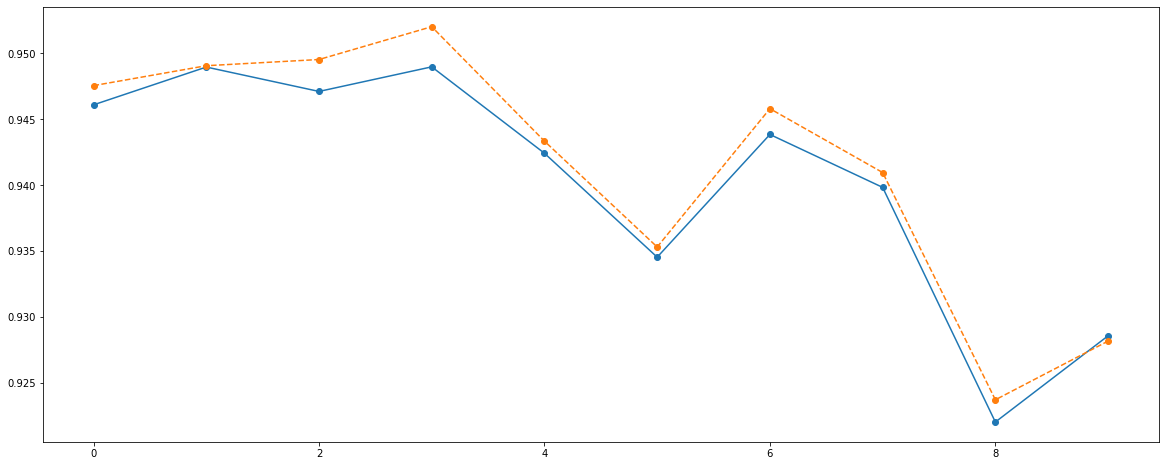

In [ ]:
x_len = range(len(after_R2_100))
plt.figure(figsize=(20,8))
plt.plot(x_len, before_R2_100, 'o-')
plt.plot(x_len, after_R2_100, 'o--')

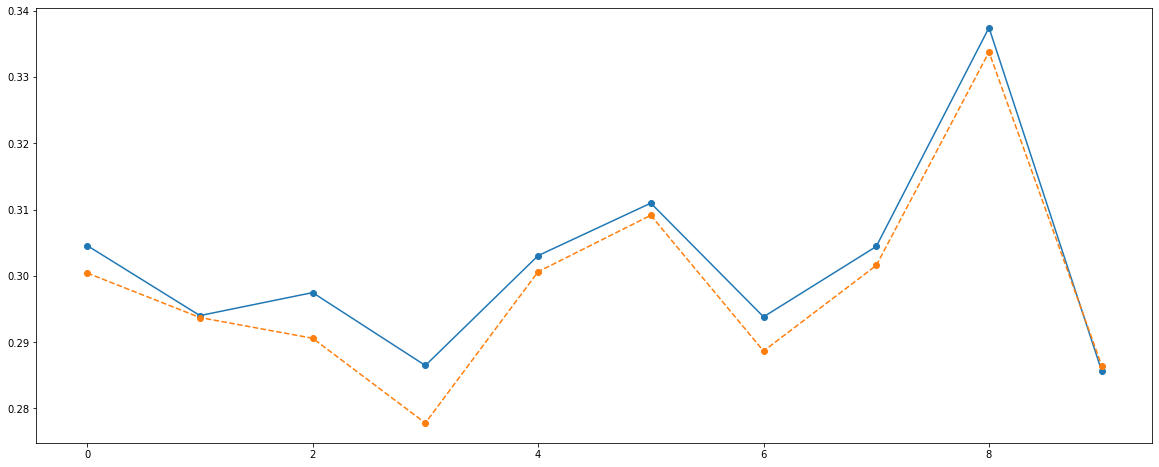

In [ ]:
x_len = range(len(after_RMSE_100))
plt.figure(figsize=(20,8))
plt.plot(x_len, before_RMSE_100, 'o-')
plt.plot(x_len, after_RMSE_100, 'o--')

In [ ]:
print(np.mean(before_R2_100))
print(np.mean(after_R2_100))
print(np.mean(before_RMSE_100))
print(np.mean(after_RMSE_100))

0.9402439814543528
0.9416163980757014
0.3017813829752357
0.2981169801237147


In [ ]:
print(np.mean(before_R2_100))
print(np.mean(after_R2_100))
print(np.mean(before_RMSE_100))
print(np.mean(after_RMSE_100))

0.9402439814543528
0.9415519838757568
0.3017813829752357
0.29826548763095334


In [ ]:
f100 = pd.DataFrame(zip(before_R2_100, after_R2_100,before_RMSE_100,after_RMSE_100), columns = ['before_r2_f100', 'after_R2_f100','before_RMSE_f100','after_RMSE_f100'])

In [ ]:
f100 =f100.reindex([0,2,3,4,5,6,7,8,9,1])

In [ ]:
ㄹ100  

In [ ]:
f100

,before_r2_f100,after_R2_f100,before_RMSE_f100,after_RMSE_f100
0,0.946097,0.947533,0.304565,0.300481
2,0.947113,0.949492,0.297467,0.290699
3,0.948977,0.952064,0.286473,0.277673
4,0.942425,0.943363,0.303040,0.300561
5,0.934546,0.935332,0.310965,0.309092
6,0.943850,0.946165,0.293811,0.287692
7,0.939838,0.940748,0.304427,0.302114
8,0.922046,0.923750,0.337427,0.333718
9,0.928585,0.928571,0.285638,0.285666
1,0.948961,0.949144,0.294002,0.293474
